Using device: cuda
all the same shape torch.Size([100])
Training model...
Epoch 0, Loss: 0.5560
Epoch 100, Loss: 0.1532
Epoch 200, Loss: 0.5792
Epoch 300, Loss: 0.2816
Epoch 400, Loss: 0.3025
Epoch 500, Loss: 0.1818
Epoch 600, Loss: 0.2129
Epoch 700, Loss: 0.2298
Epoch 800, Loss: 0.3378
Epoch 900, Loss: 0.2168
Epoch 1000, Loss: 0.4868
Epoch 1100, Loss: 0.4939
Epoch 1200, Loss: 0.2351
Epoch 1300, Loss: 0.2412
Epoch 1400, Loss: 0.4642
Epoch 1500, Loss: 0.2586
Epoch 1600, Loss: 0.3334
Epoch 1700, Loss: 0.4140
Epoch 1800, Loss: 0.6732


<ipython-input-7-bdf73474ceae>:142: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 10, figsize=(28, 3))


Epoch 1900, Loss: 0.6167
Epoch 2000, Loss: 0.2082
Epoch 2100, Loss: 0.3290
Epoch 2200, Loss: 0.4029
Epoch 2300, Loss: 0.1796
Epoch 2400, Loss: 0.3757
Epoch 2500, Loss: 0.4197
Epoch 2600, Loss: 0.3629
Epoch 2700, Loss: 0.2550
Epoch 2800, Loss: 0.5045
Epoch 2900, Loss: 0.2877
Epoch 3000, Loss: 0.3078
Epoch 3100, Loss: 0.6890
Epoch 3200, Loss: 0.3377
Epoch 3300, Loss: 0.3384
Epoch 3400, Loss: 0.2654
Epoch 3500, Loss: 0.3998
Epoch 3600, Loss: 0.3579
Epoch 3700, Loss: 0.3537
Epoch 3800, Loss: 0.4308
Epoch 3900, Loss: 0.4180


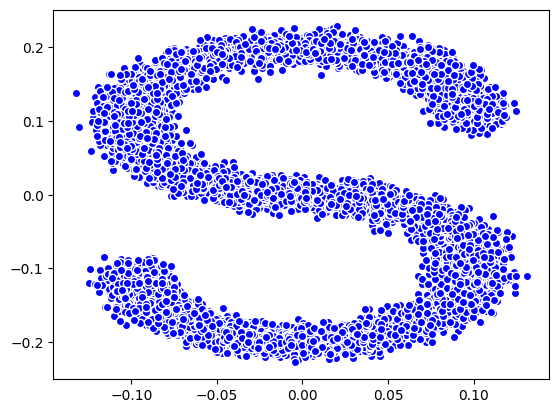

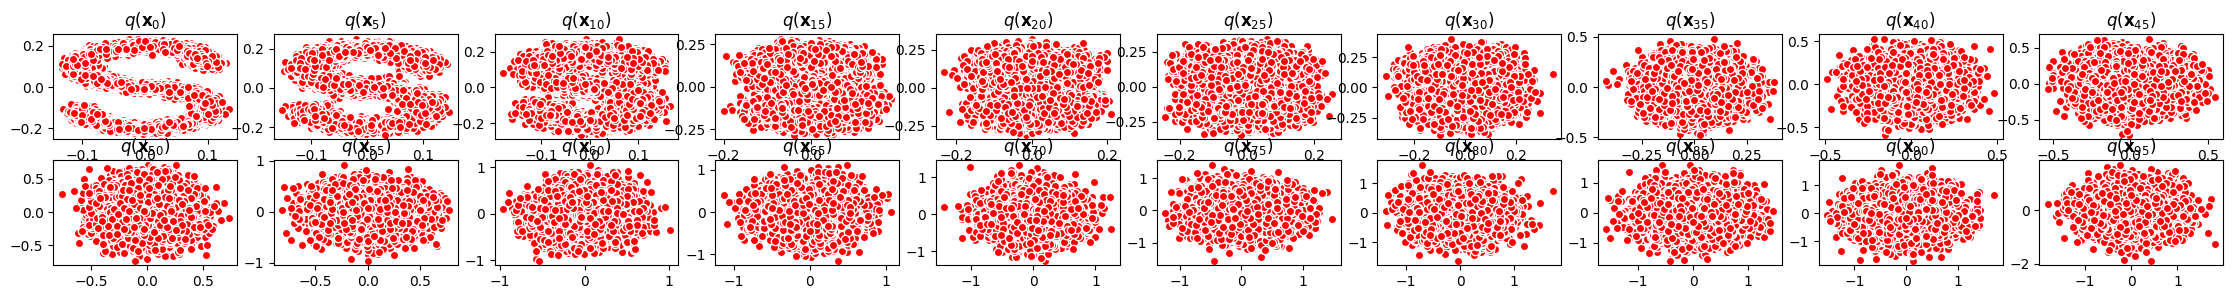

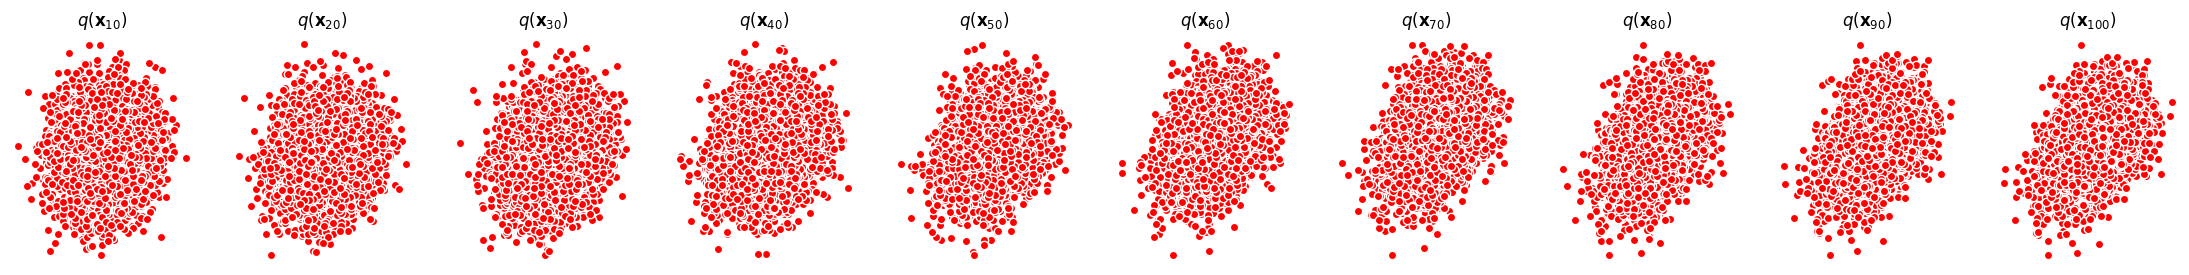

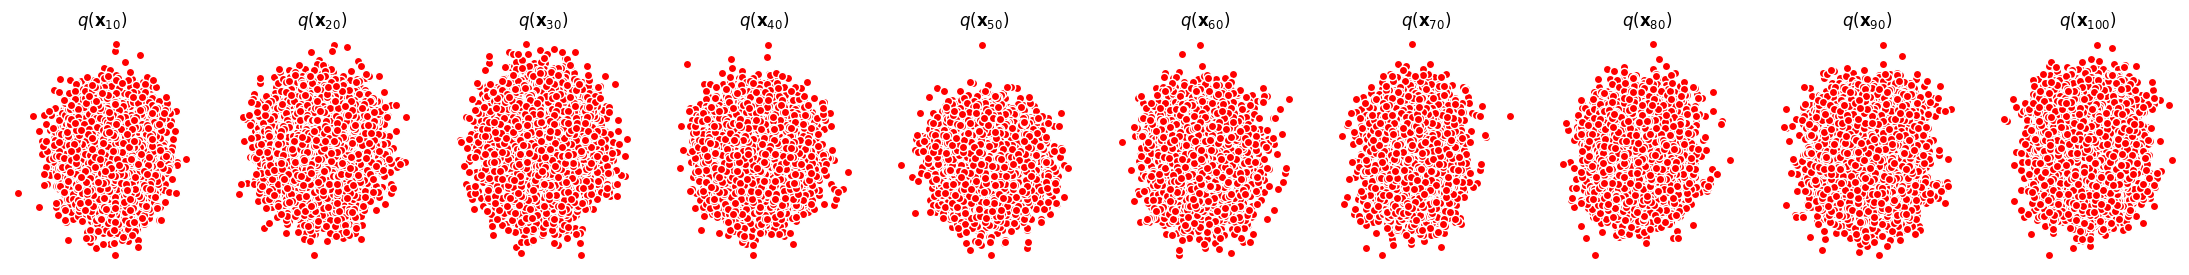

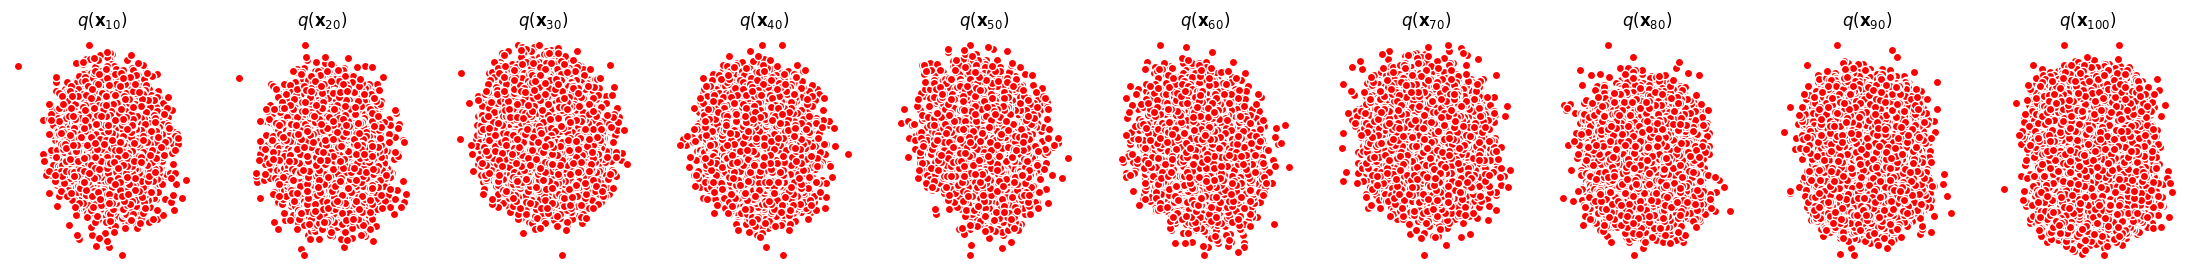

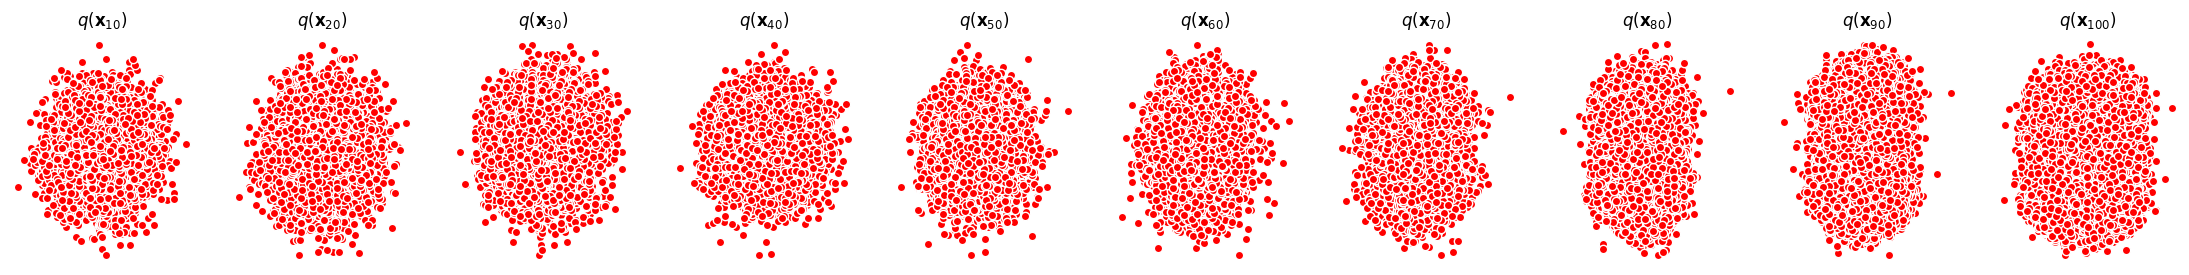

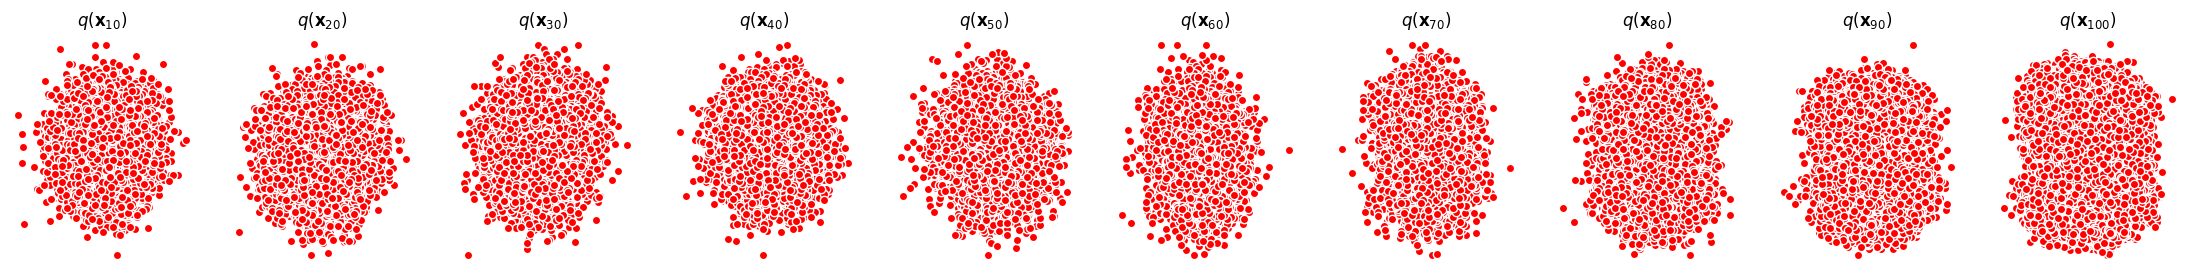

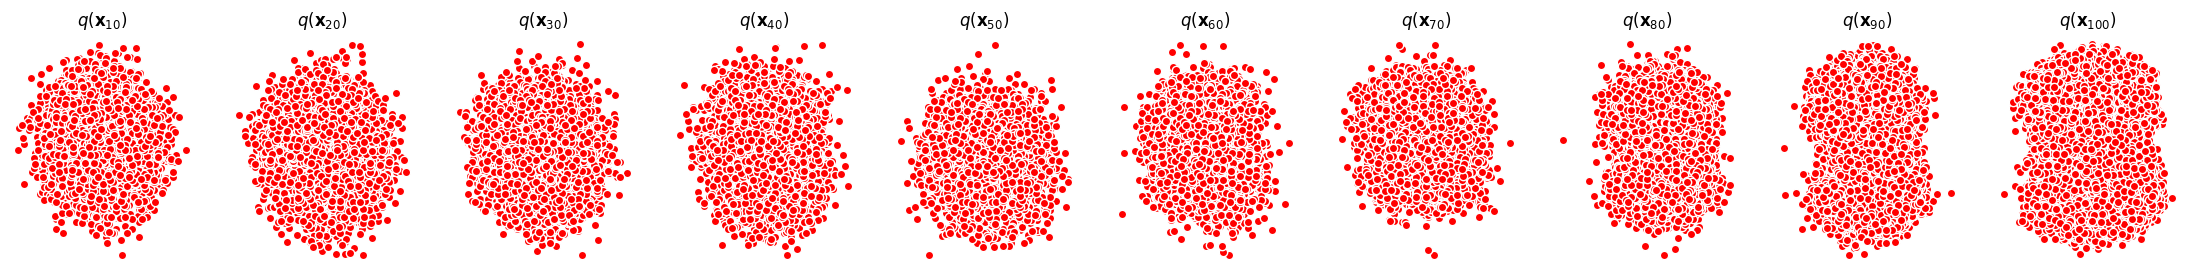

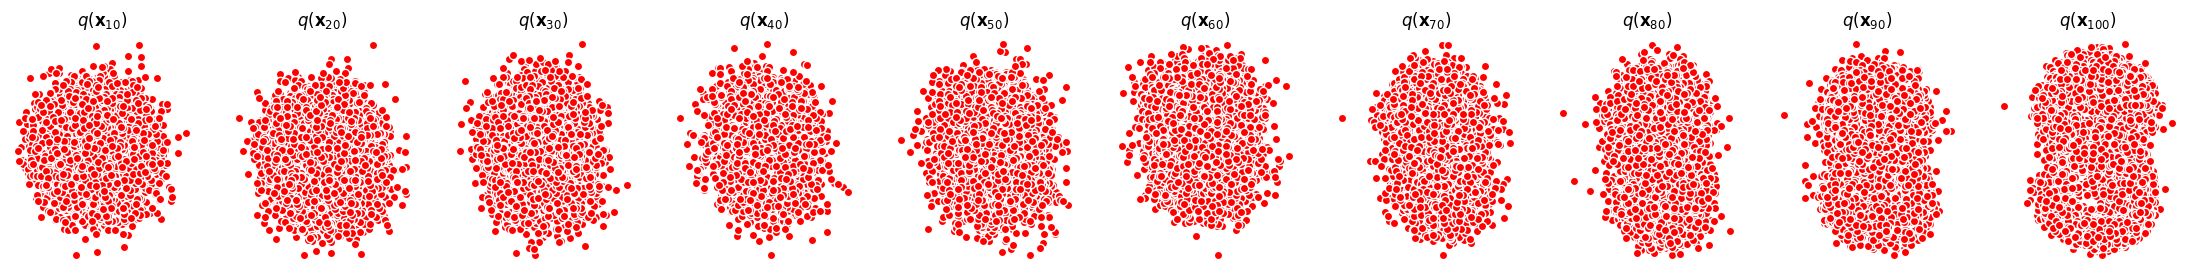

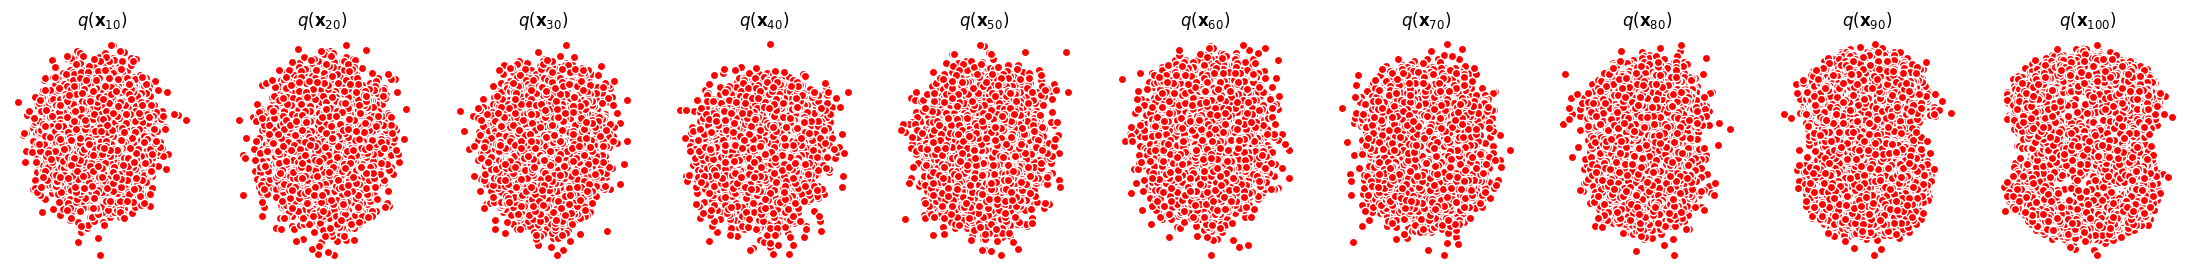

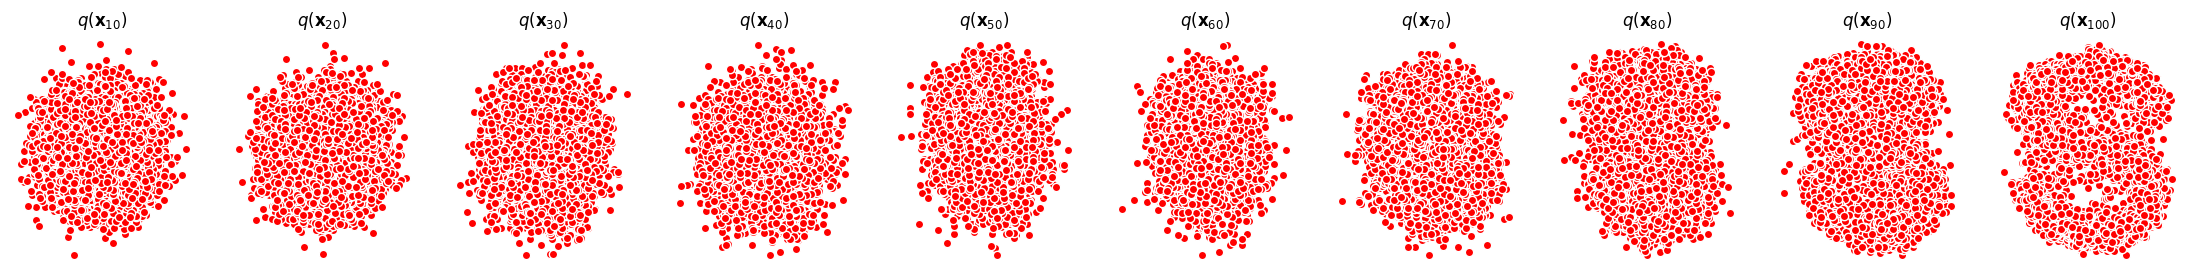

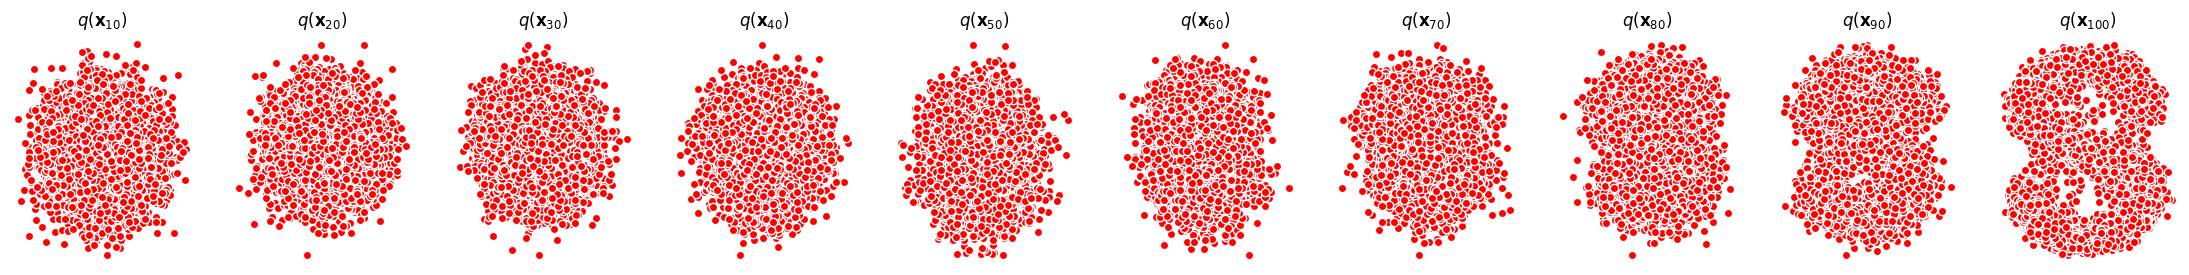

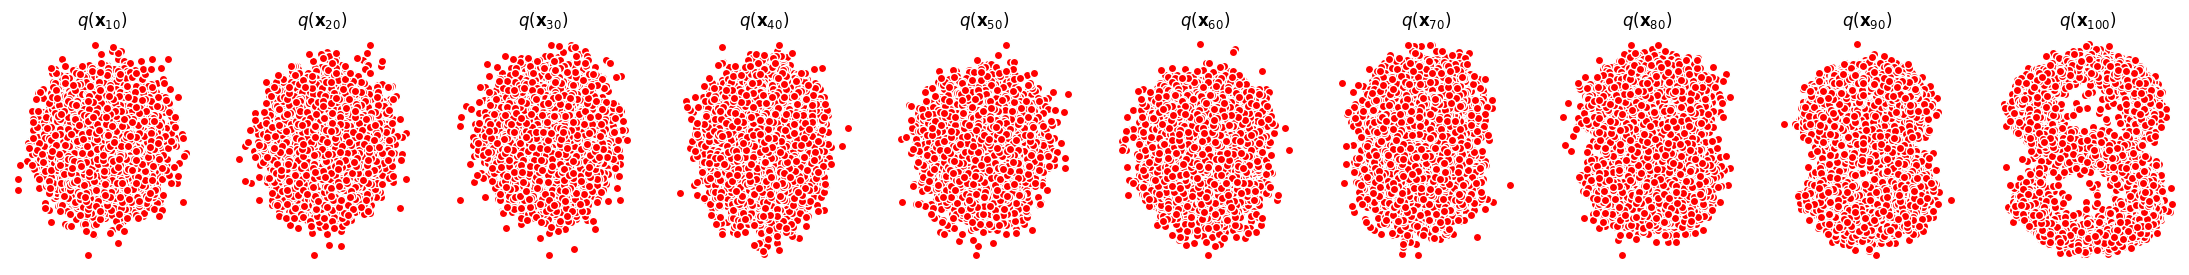

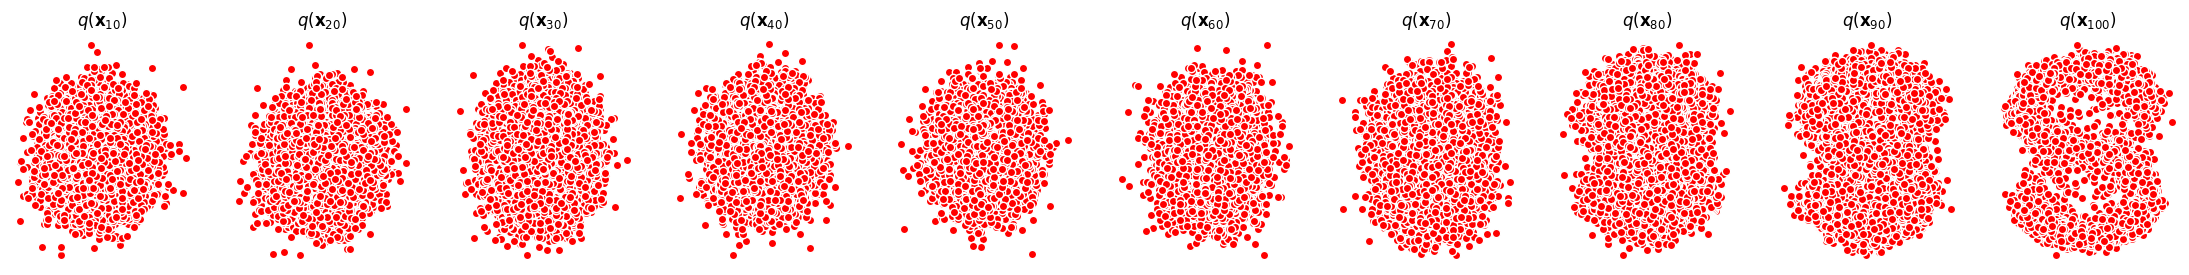

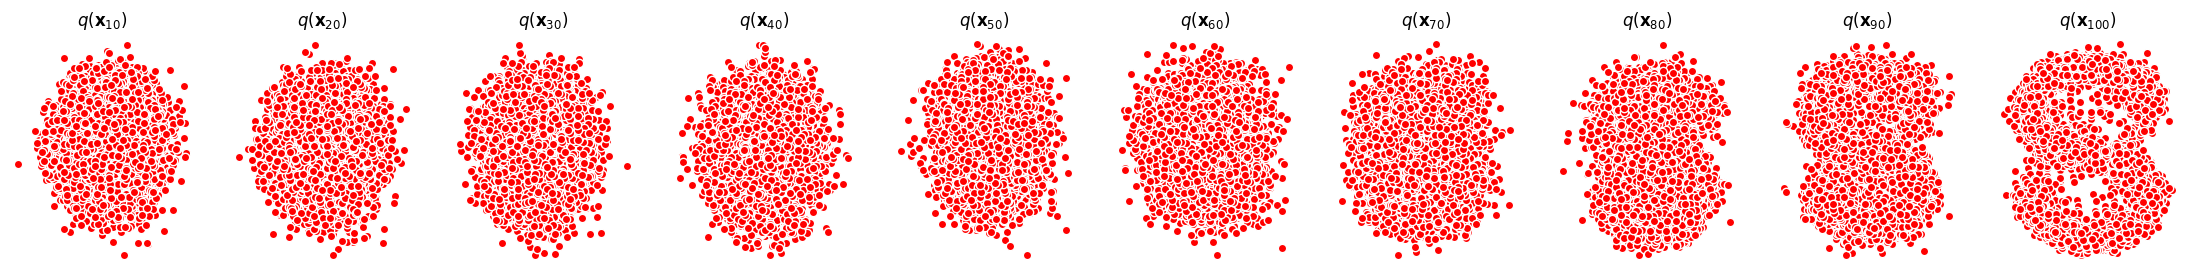

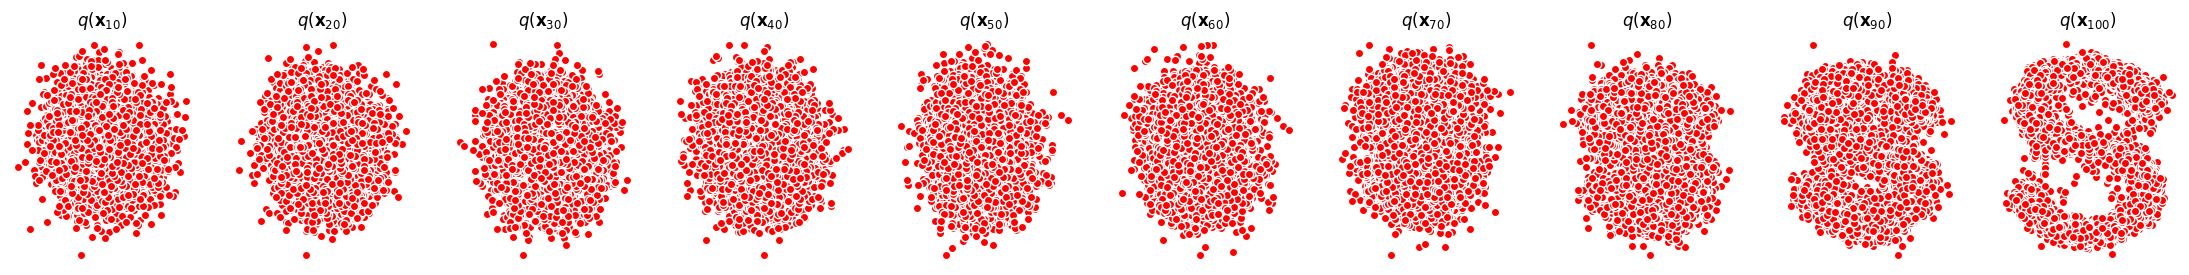

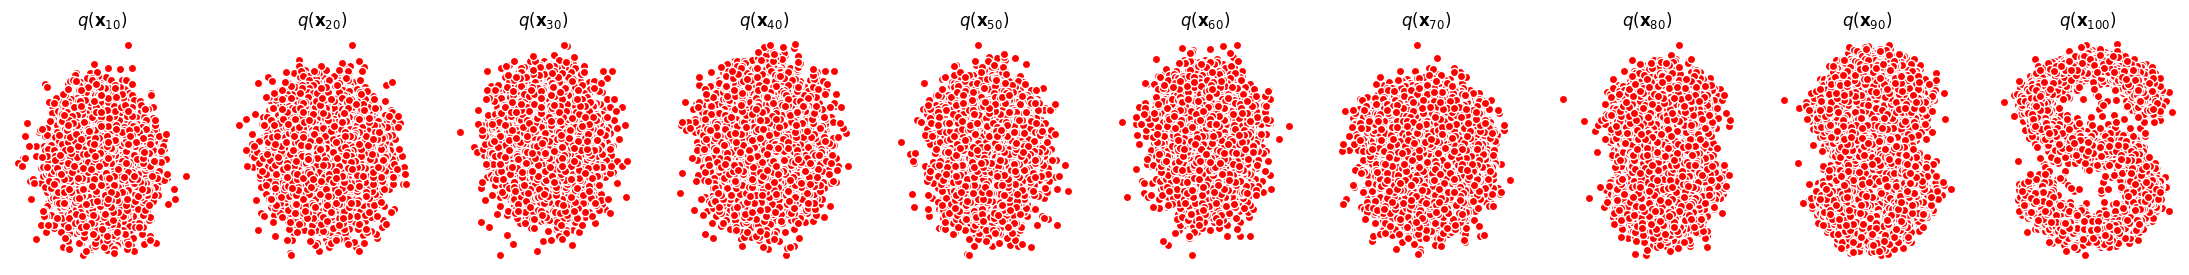

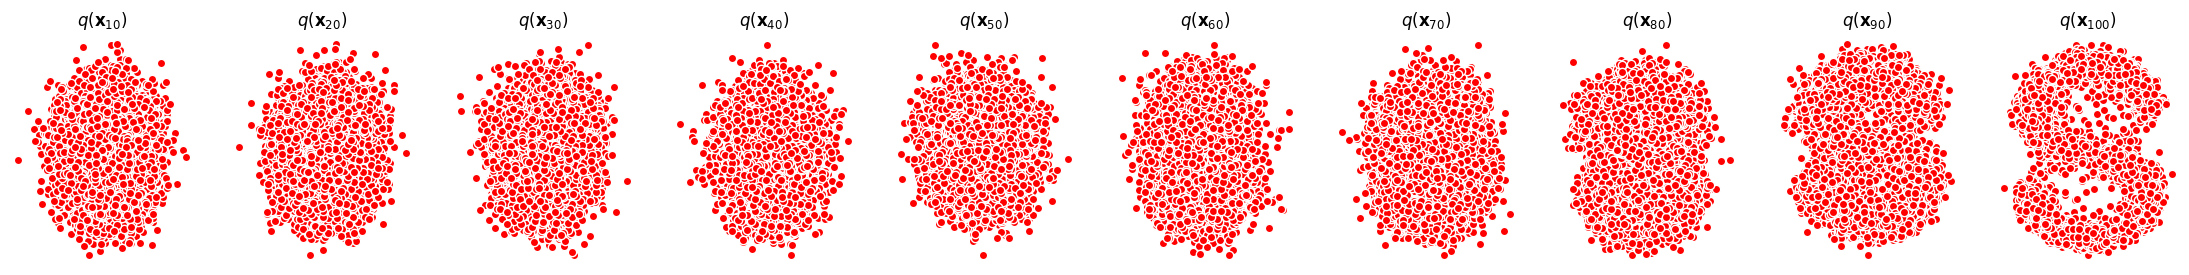

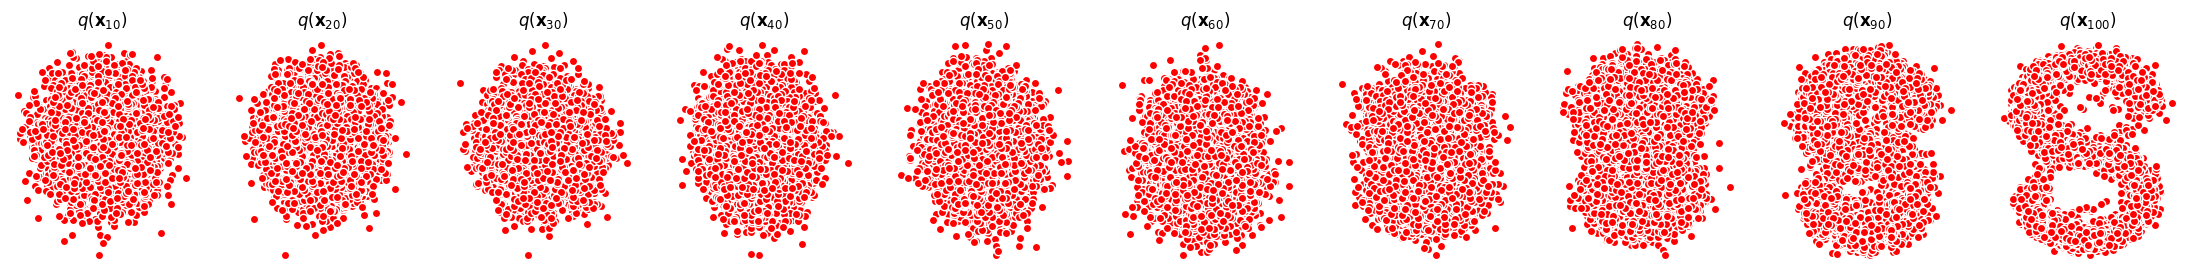

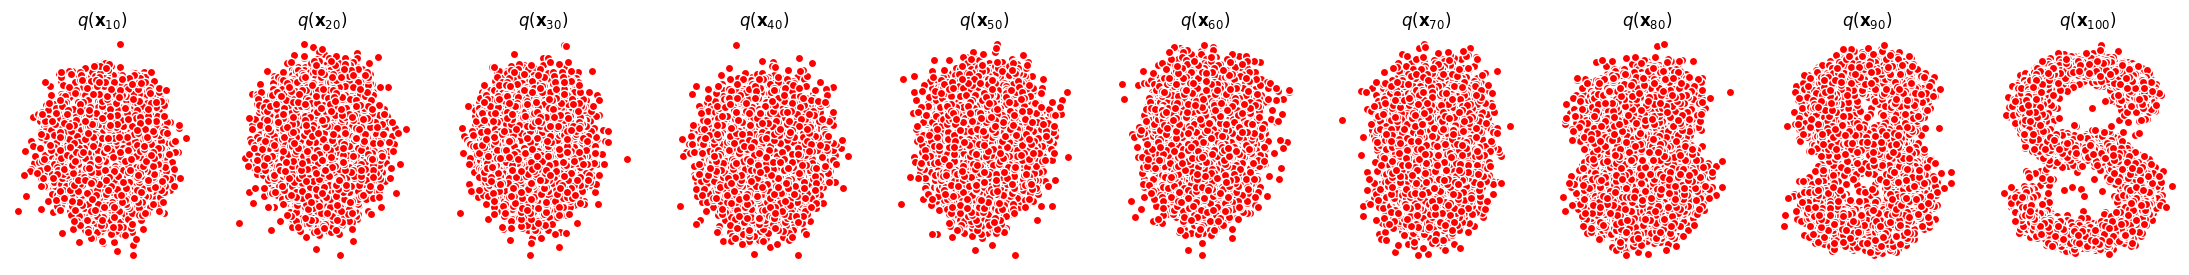

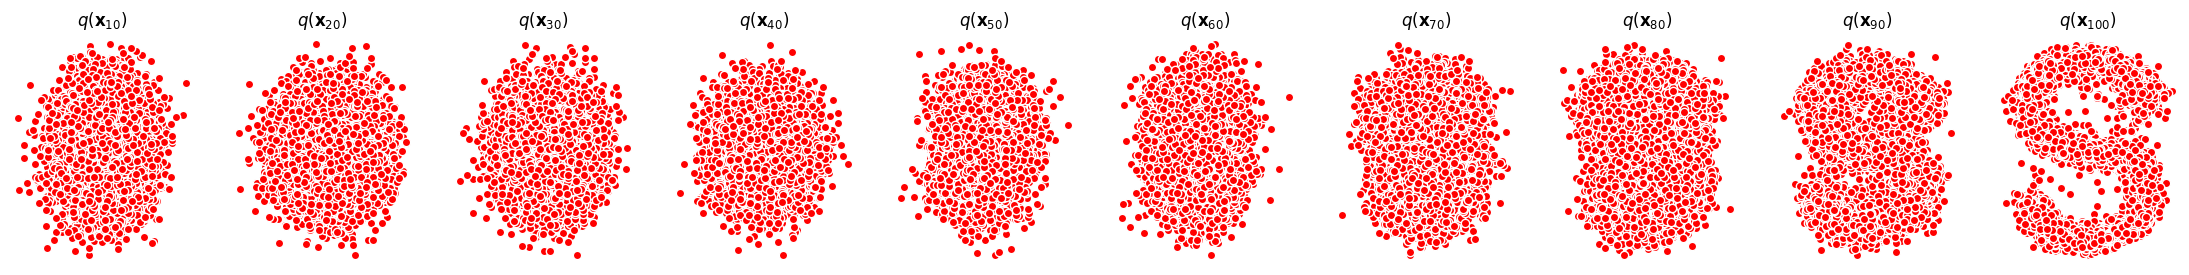

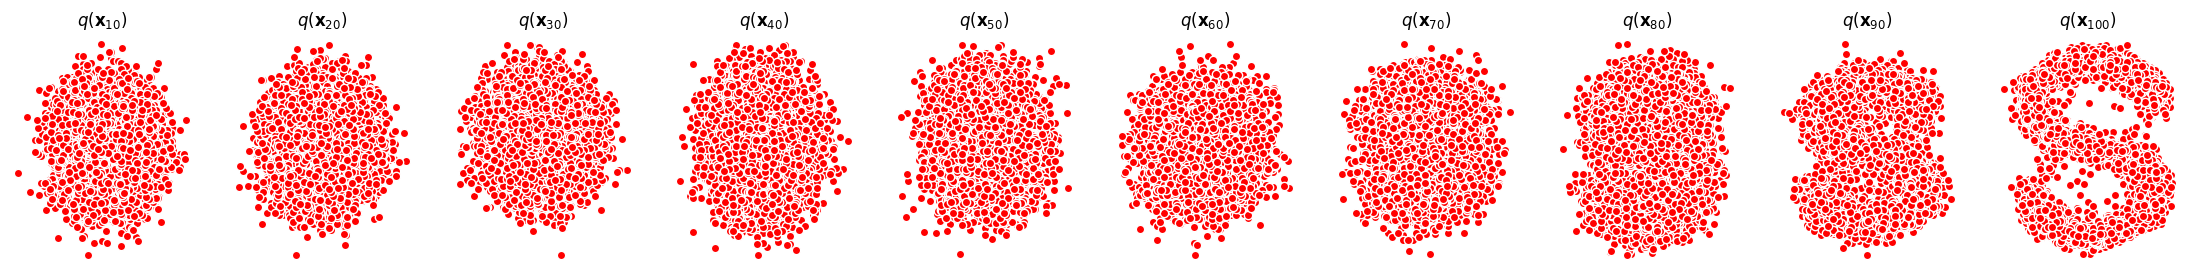

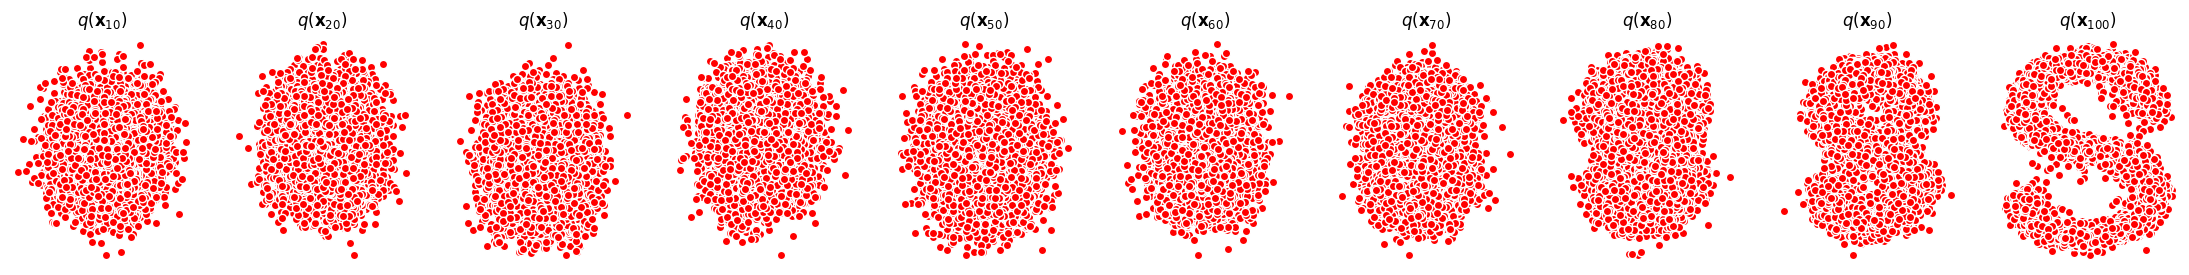

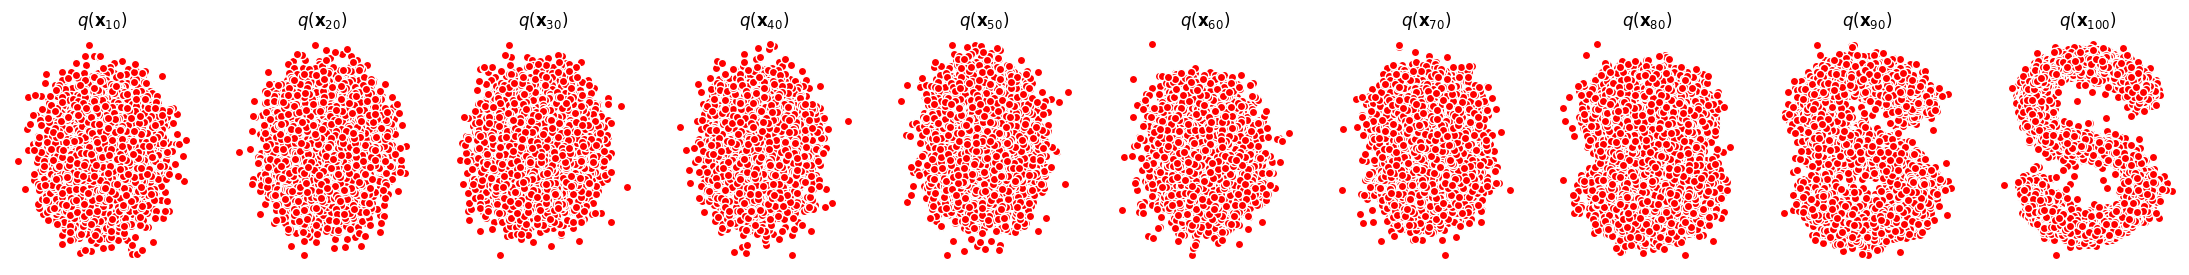

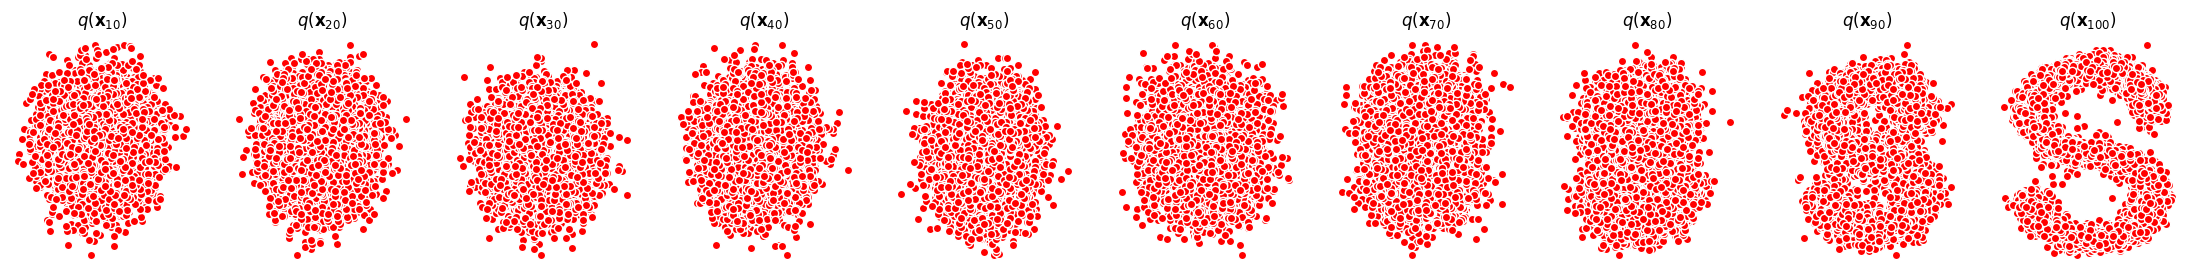

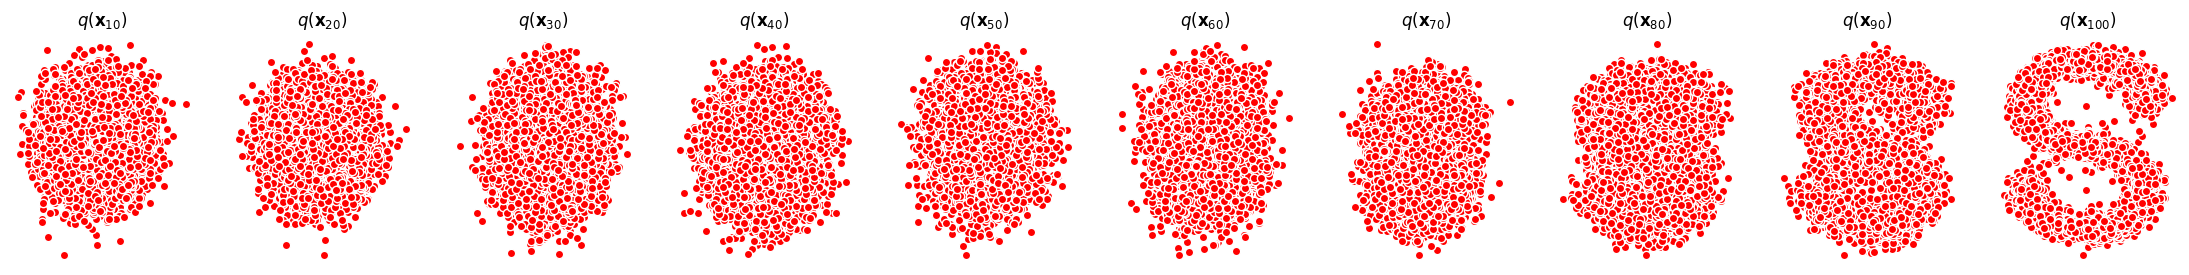

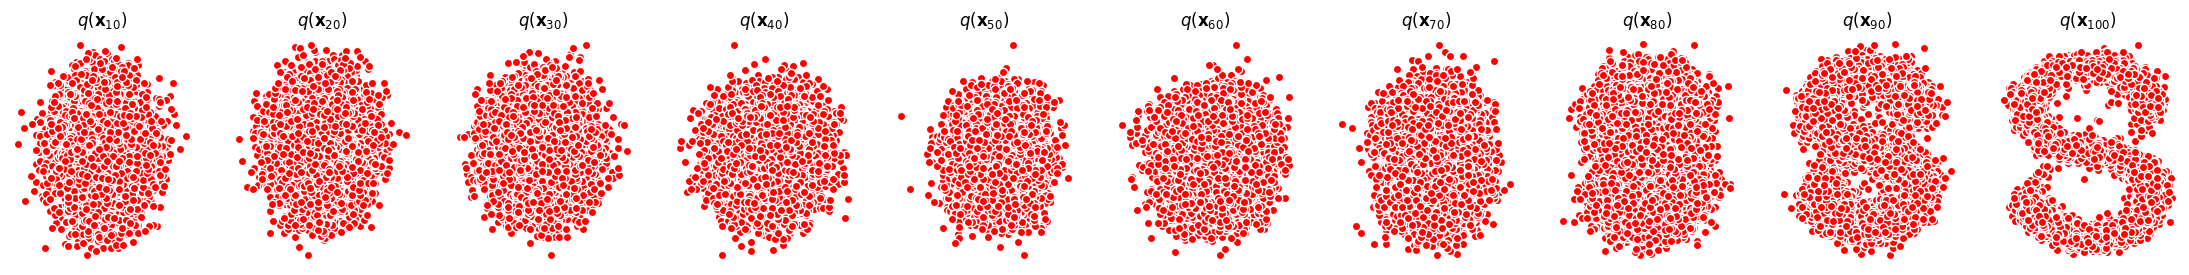

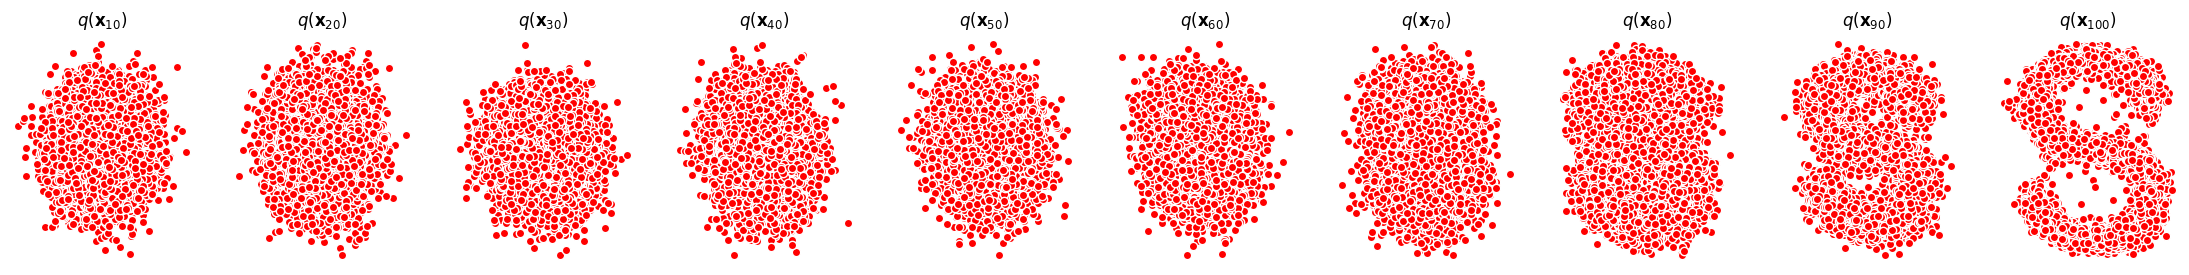

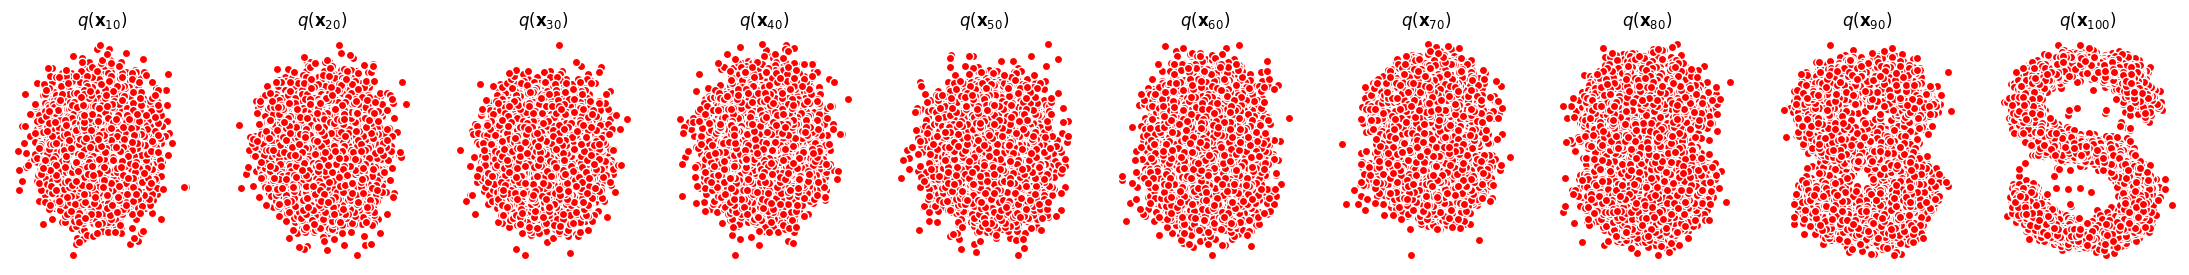

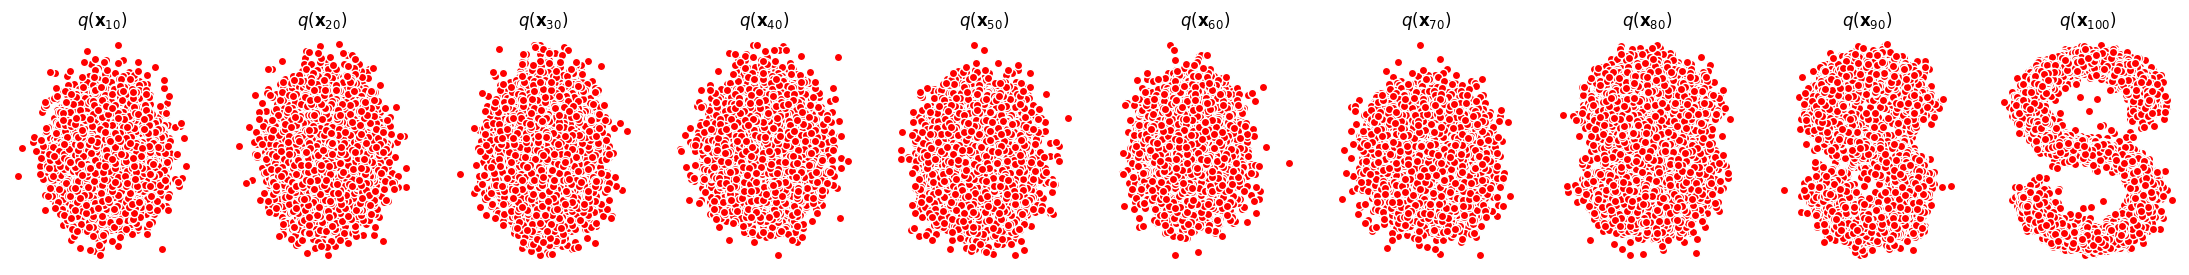

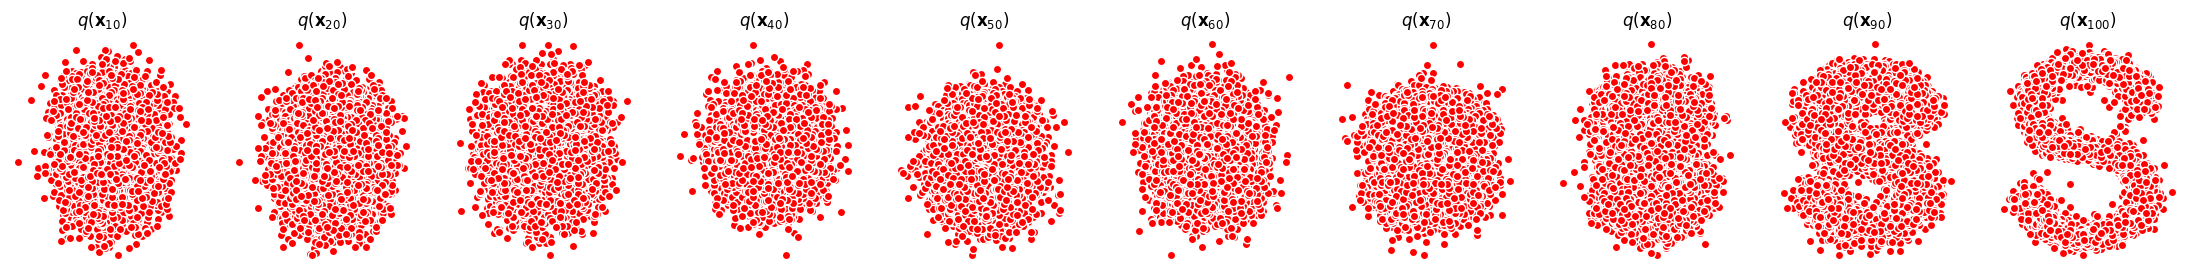

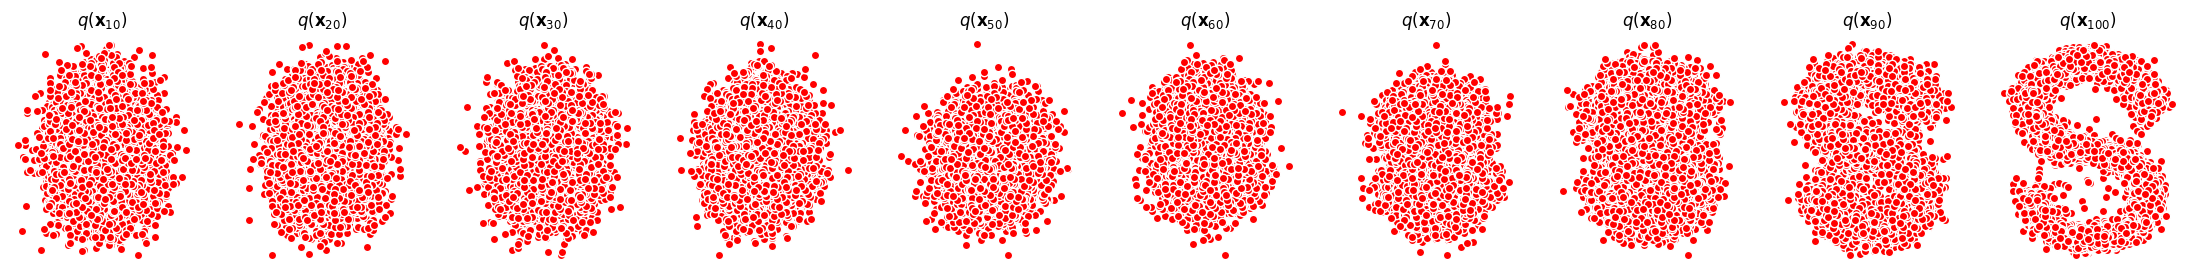

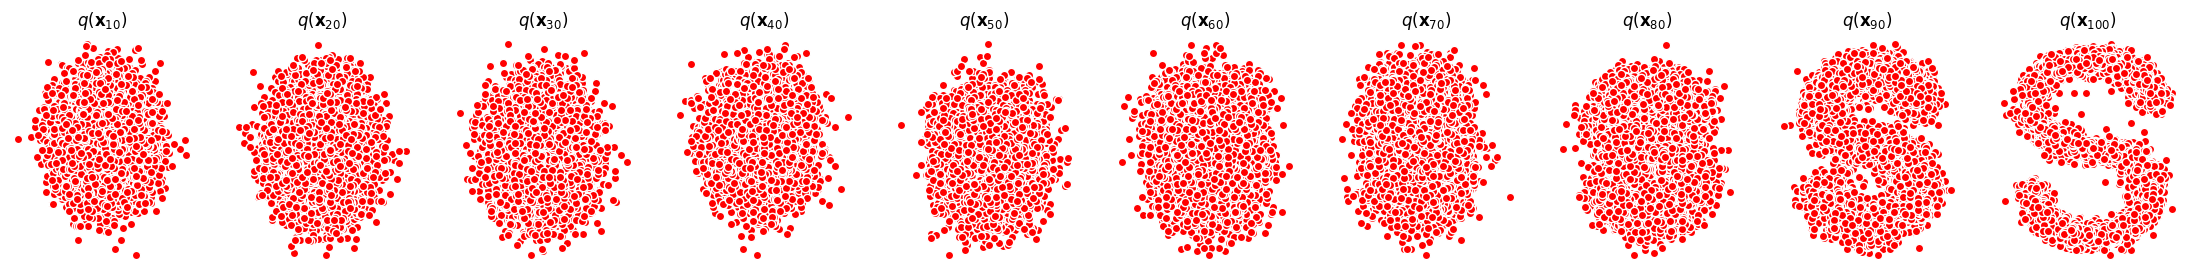

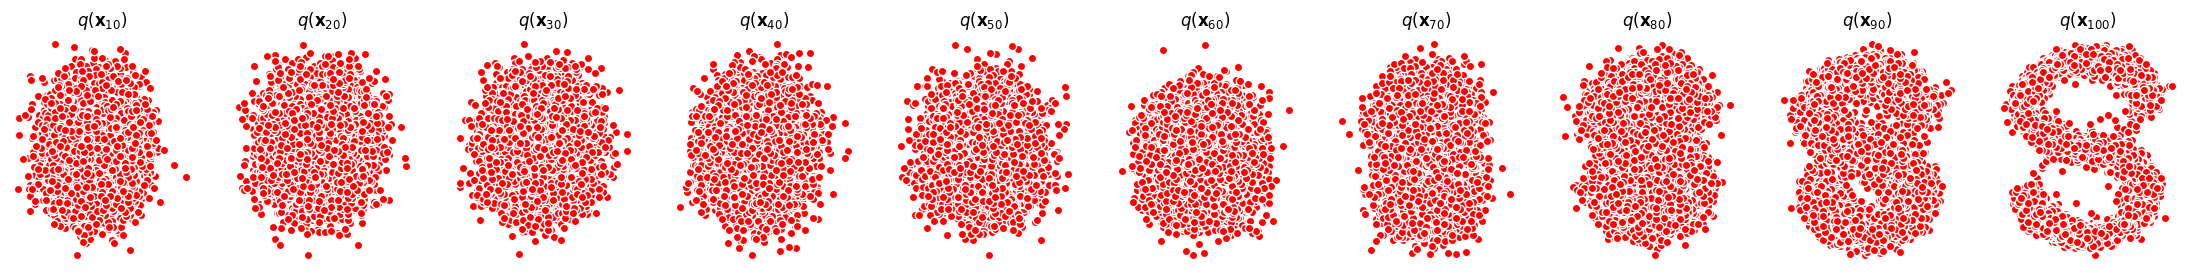

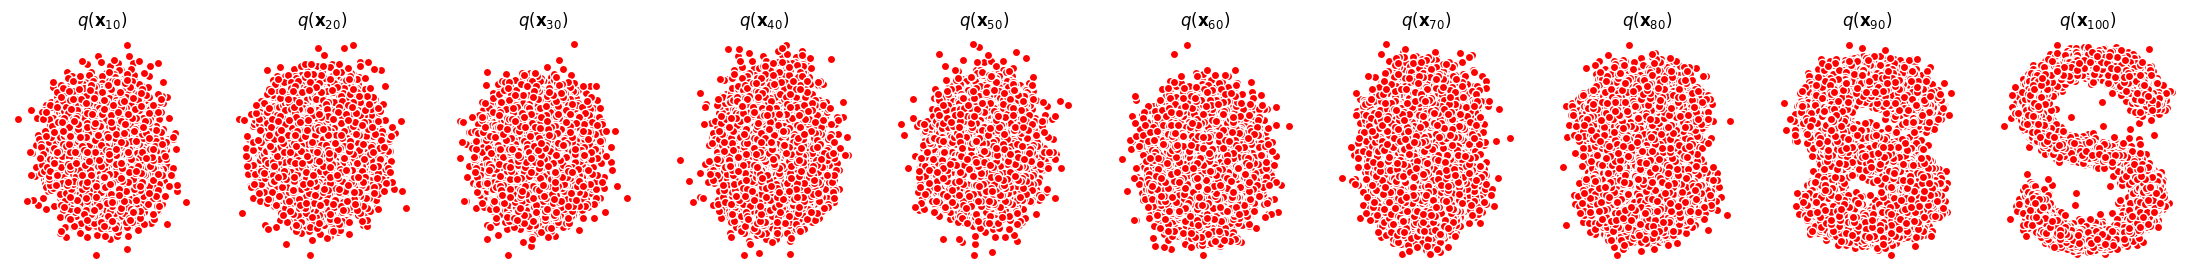

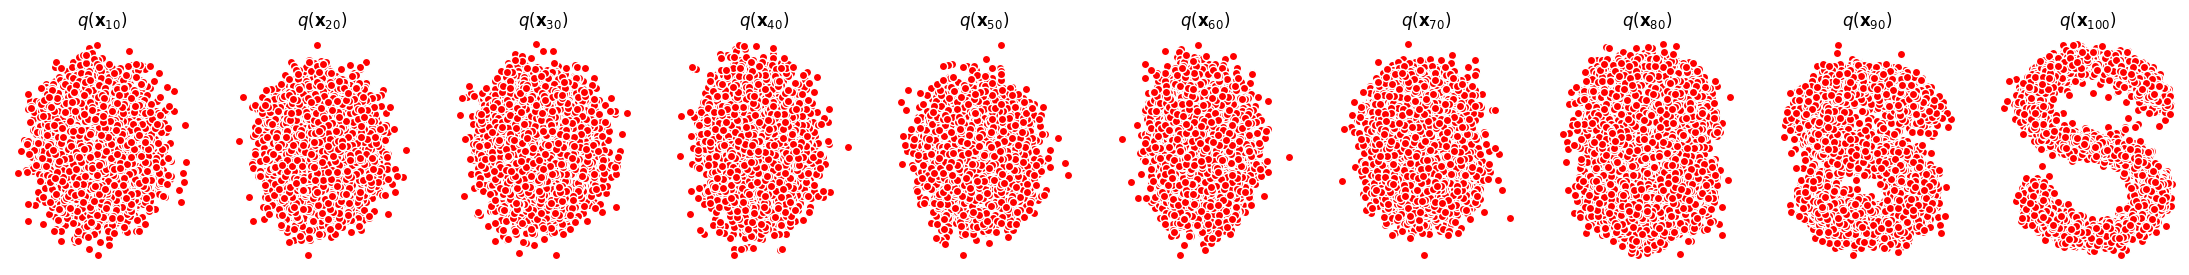

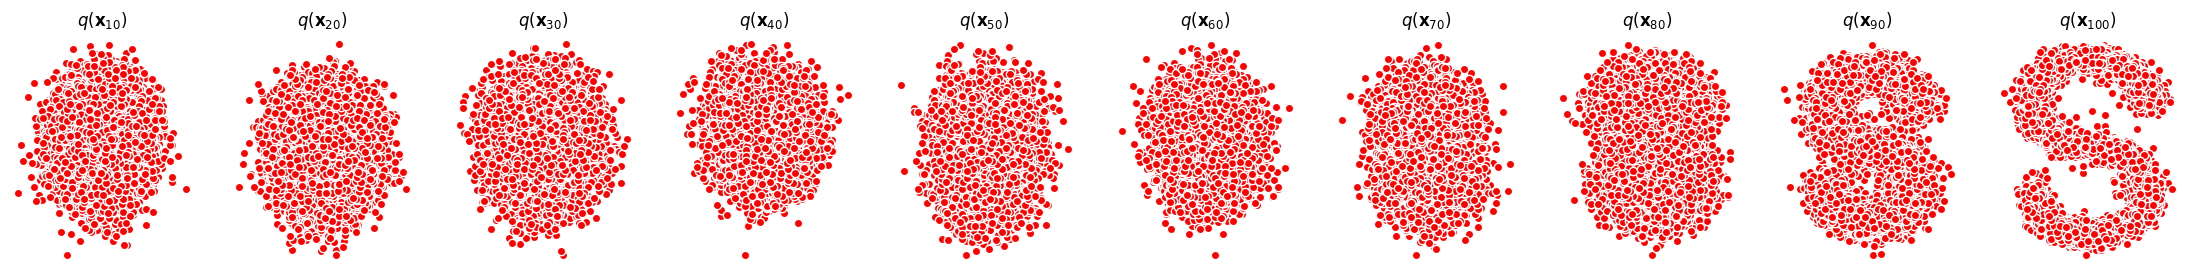

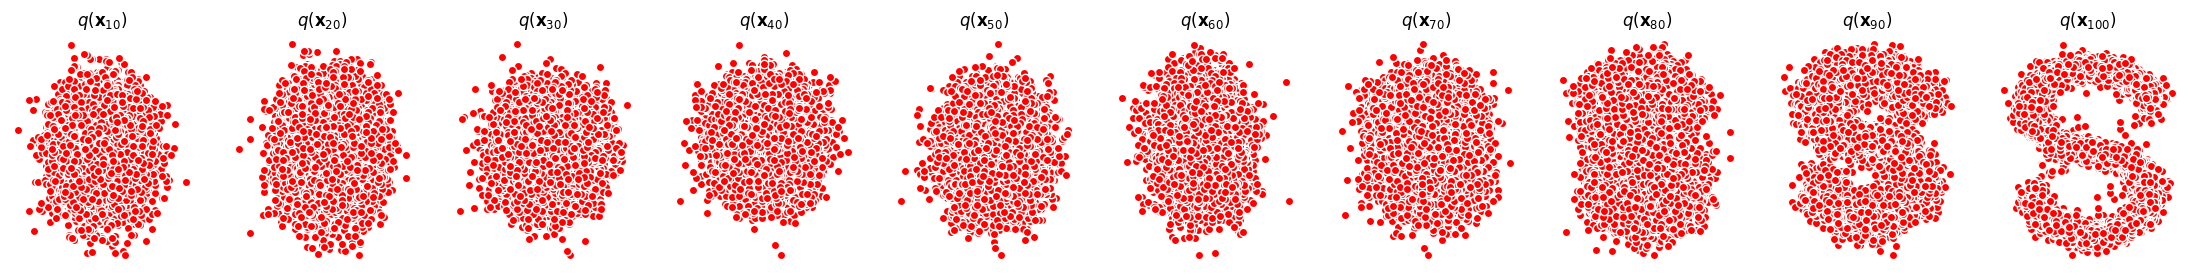

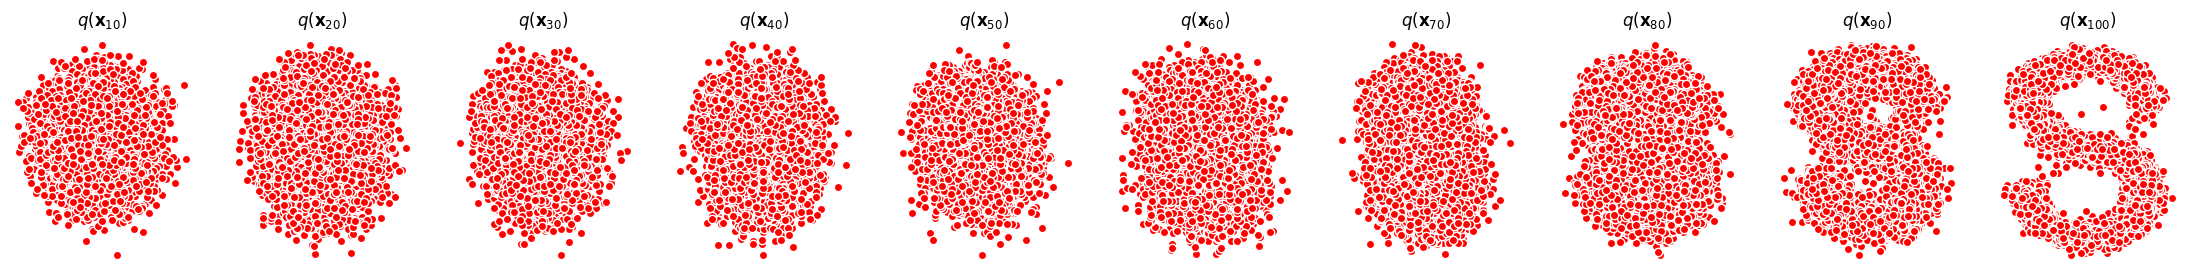

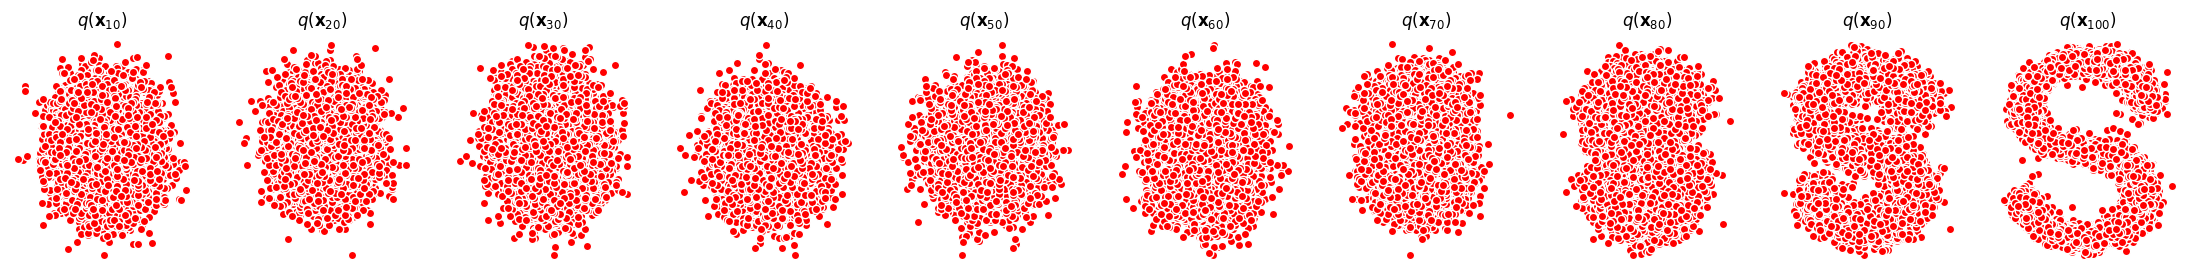

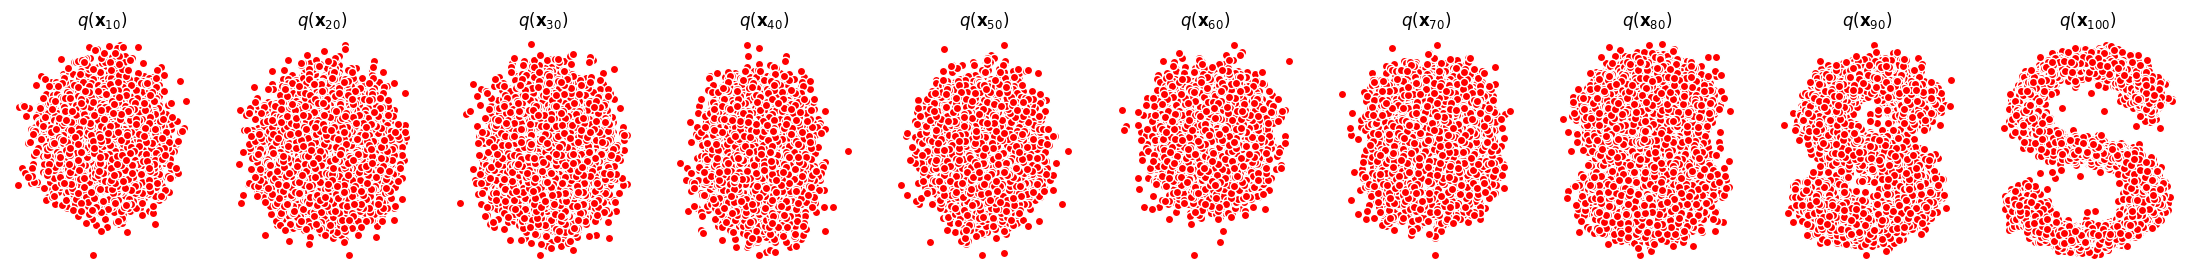

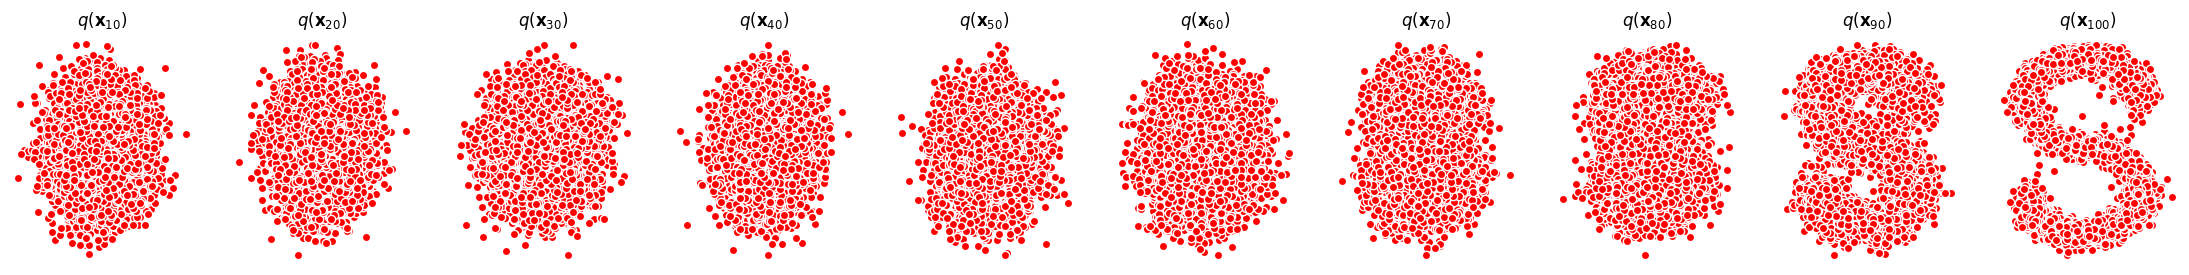

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
import torch.nn as nn

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 生成数据
s_curve, _ = make_s_curve(10 ** 4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0
data = s_curve.T
dataset = torch.tensor(s_curve, dtype=torch.float32).to(device)

# 显示原始数据
fig, ax = plt.subplots()
ax.scatter(*data, color='blue', edgecolor='white')

# 生成betas和相关系数
num_steps = 100
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1.], device=device), alphas_prod[:-1].to(device)], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

# 全部移动到 device
betas = betas.to(device)
alphas = alphas.to(device)
alphas_prod = alphas_prod.to(device)
alphas_prod_p = alphas_prod_p.to(device)
alphas_bar_sqrt = alphas_bar_sqrt.to(device)
one_minus_alphas_bar_log = one_minus_alphas_bar_log.to(device)
one_minus_alphas_bar_sqrt = one_minus_alphas_bar_sqrt.to(device)

print("all the same shape", betas.shape)

# 正向加噪函数
def q_x(x_0, t):
    noise = torch.randn_like(x_0).to(device)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return alphas_t * x_0 + alphas_1_m_t * noise

# 可视化加噪过程
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='black')
for i in range(num_shows):
    j, k = divmod(i, 10)
    t_step = torch.tensor([i * num_steps // num_shows], device=device)
    q_i = q_x(dataset, t_step)
    axs[j, k].scatter(q_i[:, 0].cpu(), q_i[:, 1].cpu(), color='red', edgecolor='white')
    axs[j, k].set_title(rf'$q(\mathbf{{x}}_{{{i * 5}}})$')

# 模型定义
class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super().__init__()
        self.linears = nn.ModuleList([
            nn.Linear(2, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, 2),
        ])
        self.step_embeddings = nn.ModuleList([
            nn.Embedding(n_steps, num_units),
            nn.Embedding(n_steps, num_units),
            nn.Embedding(n_steps, num_units),
        ])

    def forward(self, x, t):
        for idx, emb in enumerate(self.step_embeddings):
            t_emb = emb(t)
            x = self.linears[2 * idx](x)
            x += t_emb
            x = self.linears[2 * idx + 1](x)
        return self.linears[-1](x)

# 损失函数
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    t = torch.randint(0, n_steps, size=(batch_size // 2,), device=device)
    t = torch.cat([t, n_steps - 1 - t], dim=0).unsqueeze(-1)

    a = alphas_bar_sqrt[t]
    aml = one_minus_alphas_bar_sqrt[t]

    e = torch.randn_like(x_0).to(device)
    x = x_0 * a + e * aml

    output = model(x, t.squeeze(-1))
    return (e - output).square().mean()

# 反向过程：单步
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t], device=device)
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1 - betas[t]).sqrt()) * (x - coeff * eps_theta)
    z = torch.randn_like(x).to(device)
    sigma_t = betas[t].sqrt()
    return mean + sigma_t * z

# 反向过程：完整生成
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape).to(device)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

# 训练
print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000

model = MLPDiffusion(num_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epoch):
    for batch_x in dataloader:
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach().cpu()
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
            axs[i - 1].set_axis_off()
            axs[i - 1].set_title(f'$q(\\mathbf{{x}}_{{{i * 10}}})$')
